In [1]:
import pandas as pd ,numpy as np, matplotlib.pyplot as plt, seaborn as sns,os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures,StandardScaler


In [2]:
os.chdir('..')
DATA_PATH = os.path.join('research\Green Chilly Prices 21-25.csv')

In [3]:
data_frame = pd.read_csv(DATA_PATH)
dollar_df = pd.read_csv('research/USD_LKR Historical Data.csv')

<Axes: xlabel='date'>

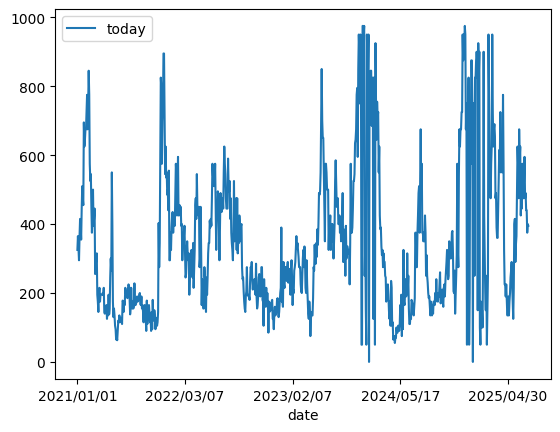

In [4]:
data_frame.plot(x='date',y='today',kind='line')

In [5]:
data_frame['today_smooth'] = data_frame['today'].rolling(window=7, min_periods=1).mean()
data_frame['month'] = pd.to_datetime(data_frame['date']).dt.month


monthly_avg_df = data_frame.groupby('month')['today'].mean().reset_index()

# Optional: Add month names
monthly_avg_df['month_name'] = monthly_avg_df['month'].map({
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
})

<Axes: xlabel='date'>

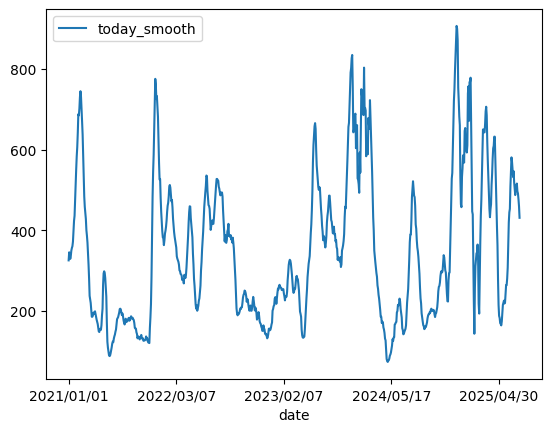

In [6]:
data_frame.plot(x='date',y='today_smooth',kind='line')

<Axes: xlabel='month'>

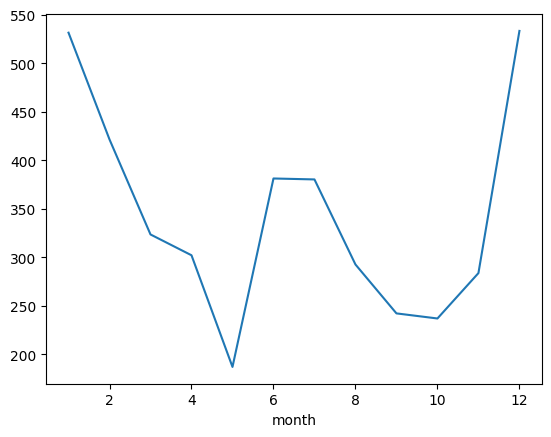

In [7]:
monthly_avg_df.plot(x='month', y='today', legend=False)

In [8]:
dollar_df['date'] = pd.to_datetime(dollar_df['Date'])

dollar_df['year_month'] = dollar_df['date'].dt.to_period('M')

monthly_dollar_rate_avg = dollar_df.groupby('year_month')['Price'].mean().reset_index()
monthly_dollar_rate_avg.set_index('year_month', inplace=True)
monthly_dollar_rate_avg.rename(columns={'Price': 'dollar_rate'}, inplace=True)
print(monthly_dollar_rate_avg.loc['2021-01']['dollar_rate'])
print(dollar_df.head())
print(monthly_dollar_rate_avg.head())

191.75
         Date    Price     Open    High      Low Vol. Change %       date  \
0  07/04/2025  300.025  299.925  300.65  299.925  NaN    0.03% 2025-07-04   
1  07/03/2025  299.925  299.925  300.05  299.850  NaN    0.00% 2025-07-03   
2  07/02/2025  299.925  300.050  300.05  299.840  NaN   -0.01% 2025-07-02   
3  07/01/2025  299.950  299.950  300.05  299.800  NaN   -0.02% 2025-07-01   
4  06/30/2025  300.000  299.800  300.00  299.725  NaN    0.05% 2025-06-30   

  year_month  
0    2025-07  
1    2025-07  
2    2025-07  
3    2025-07  
4    2025-06  
            dollar_rate
year_month             
2021-01      191.750000
2021-02      194.650000
2021-03      197.494565
2021-04      197.352273
2021-05      197.273810


In [9]:
print(data_frame.head())
data_frame['date'] = pd.to_datetime(data_frame['date'])
data_frame['year_month'] = data_frame['date'].dt.to_period('M')

data_frame = data_frame.merge(monthly_dollar_rate_avg, left_on='year_month', right_index=True, how='left')
print(data_frame.head())
# data_frame['today'] = data_frame['today']/ monthly_dollar_rate_avg.loc[data_frame['date'].dt.to_period('M')]['Price']

         date  temp  precip  humidity  windspeed  cloudcover   dew  yesterday  \
0  2021/01/01  25.0   6.778      83.6       17.3        76.7  21.8      395.0   
1  2021/01/04  25.0  16.828      93.3       13.7        95.0  23.8      325.0   
2  2021/01/05  25.5   5.183      89.8       10.4        83.9  23.6      365.0   
3  2021/01/06  26.0   7.048      87.5        6.5        77.9  23.6      330.0   
4  2021/01/07  26.2  30.440      86.2       10.8        78.4  23.5      295.0   

   today  today_smooth  month  
0  325.0        325.00      1  
1  365.0        345.00      1  
2  330.0        340.00      1  
3  295.0        328.75      1  
4  365.0        336.00      1  
        date  temp  precip  humidity  windspeed  cloudcover   dew  yesterday  \
0 2021-01-01  25.0   6.778      83.6       17.3        76.7  21.8      395.0   
1 2021-01-04  25.0  16.828      93.3       13.7        95.0  23.8      325.0   
2 2021-01-05  25.5   5.183      89.8       10.4        83.9  23.6      365.0   
3

In [ ]:
# data_frame['price'] = data_frame['today']
# data_frame['today'] = data_frame['today']/ data_frame['dollar_rate']
# data_frame['yesterday'] = data_frame['yesterday']/ data_frame['dollar_rate']

date               2025-03-24 00:00:00
temp                              29.0
precip                           0.029
humidity                          73.3
windspeed                         14.0
cloudcover                        33.0
dew                               22.5
yesterday                     1.605108
today                         1.655796
today_smooth                619.285714
month                                3
year_month                     2025-03
dollar_rate                 295.930238
price                            490.0
last_7_day_avg                2.092675
last_30_day_avg               1.509507
year                              2025
month_avg_price               1.187777
Name: 778, dtype: object
        date  predicted_price
0 2025-03-25         1.408797
1 2025-03-26         1.402646
2 2025-03-27         1.366282
3 2025-03-28         1.340075
4 2025-03-29         1.321155
        date  predicted_price
0 2025-03-25       422.577404
1 2025-03-26       420.732571
2 2

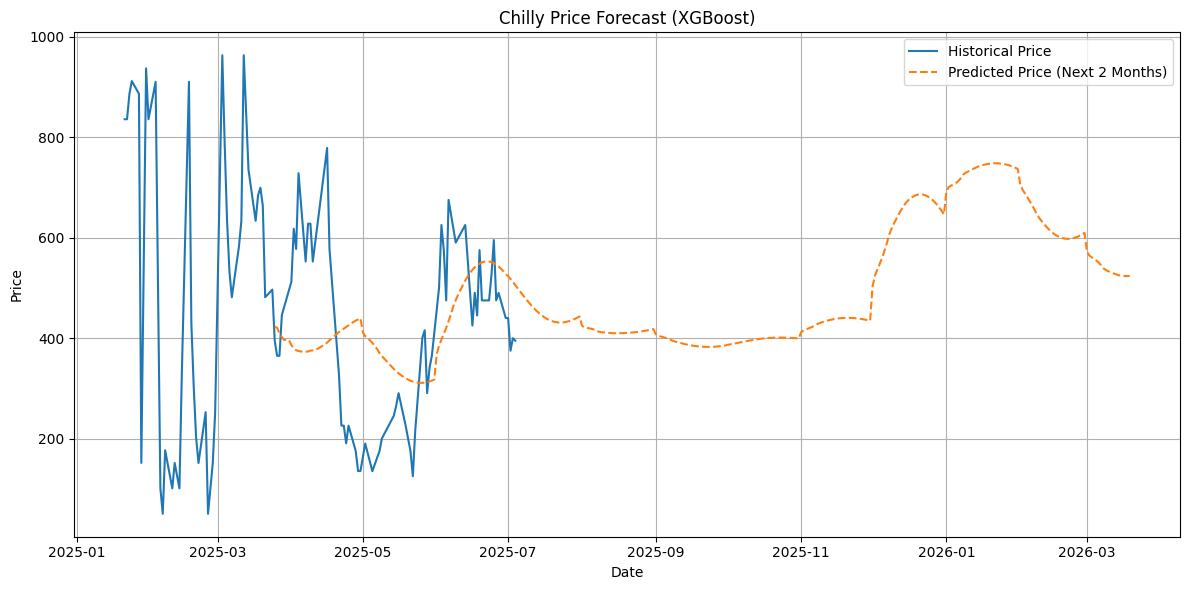

In [14]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
# ==== Step 1: Load and Preprocess ====
df = data_frame.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').copy()

# ==== Step 2: Feature Engineering ====
df['yesterday'] = df['today'].shift(1)
df['last_7_day_avg'] = df['today'].rolling(window=7).mean()
df['last_30_day_avg'] = df['today'].rolling(window=30).mean()

df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

monthly_avg = df.groupby('month')['today'].mean().to_dict()
df['month_avg_price'] = df['month'].map(monthly_avg)

# ==== Step 3: Drop NaNs ====
df.dropna(inplace=True)

# ==== Step 4: Train ====
feature_cols = [
    'yesterday', 'precip', 'last_7_day_avg',
    'last_30_day_avg', 'month', 'year', 'month_avg_price'
]
target_col = 'today'

train_split = int(len(df) * 0.8)
X_all, y_all = df[feature_cols], df[target_col]
X_train, y_train = df[train_split:][feature_cols], df[train_split:][target_col]
X_test, y_test = df[:train_split][feature_cols], df[:train_split][target_col]
# model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model = LinearRegression()
# model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
model.fit(X_train, y_train)

# ==== Step 5: Forecast Future (Next 60 days) ====
future_days = 30*12
# last_known = df.iloc[-1].copy()
last_known = df[:-60].iloc[-1].copy()
future_preds = []
print(last_known)
df_extended = df.copy()

for _ in range(future_days):
    next_date = last_known['date'] + pd.Timedelta(days=1)
    month = next_date.month
    year = next_date.year
    precip = last_known['precip']  # or use average or prediction

    # Rolling values
    recent = df_extended.tail(30).copy()
    yesterday = df_extended['today'].iloc[-1]
    last_7_avg = recent['today'].tail(7).mean()
    last_30_avg = recent['today'].mean()
    month_avg_price = monthly_avg[month]

    # Create feature row
    row = pd.DataFrame([{
        'yesterday': yesterday,
        'precip': precip,
        'last_7_day_avg': last_7_avg,
        'last_30_day_avg': last_30_avg,
        'month': month,
        'year': year,
        'month_avg_price': month_avg_price
    }])

    # Predict
    pred_price = model.predict(row)[0]

    # Append prediction to df_extended for next iteration
    new_row = {
        'date': next_date,
        'today': pred_price,
        'precip': precip,  # assumed constant or avg
    }
    df_extended = pd.concat([df_extended, pd.DataFrame([new_row])], ignore_index=True)
    df_extended['yesterday'] = df_extended['today'].shift(1)
    df_extended['last_7_day_avg'] = df_extended['today'].rolling(window=7).mean()
    df_extended['last_30_day_avg'] = df_extended['today'].rolling(window=30).mean()

    last_known = new_row
    future_preds.append((next_date, pred_price))

# ==== Step 6: Plot Forecast ====
future_df = pd.DataFrame(future_preds, columns=['date', 'predicted_price'])
print(future_df.head())
future_df['predicted_price'] = future_df['predicted_price']* data_frame['dollar_rate'].iloc[-1]  # Adjust for dollar rate
print(future_df.head())
plt.figure(figsize=(12, 6))
plt.plot(data_frame[-100:]['date'], data_frame[-100:]['today']*data_frame['dollar_rate'].iloc[-1], label='Historical Price')
plt.plot(future_df['date'], future_df['predicted_price'], label='Predicted Price (Next 2 Months)', linestyle='--')
# plt.plot([datetime(2025,i+1,1) for i in range(12)], monthly_avg_df.today, label='Predicted Price (Next 2 Months)', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Chilly Price Forecast (XGBoost)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
